# **Medical Insurance Premium Predictions**

Joe Lardie

April 2023

# **Imports**

In [1]:
# Standard Libraies
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import os

# Category encoders
import category_encoders as ce

# Pandas
from pandas import MultiIndex, Index

# XGBOOST
from xgboost import XGBRFRegressor, XGBClassifier

# Sklearn
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso ,LassoCV, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split,RandomizedSearchCV

C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# loading in data, ensuring it loaded correctly
df = pd.read_csv("/Users/davyd/Downloads/Medicalpremium.csv")
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


# **Exploratory Data Analysis**

In [3]:
# diagnostic look at the data
df.describe()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,24336.713996
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,6248.184382
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,15000.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,21000.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,23000.000000
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,28000.000000
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,40000.000000


In [4]:
# Checking for null values
df.isnull().sum()

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64

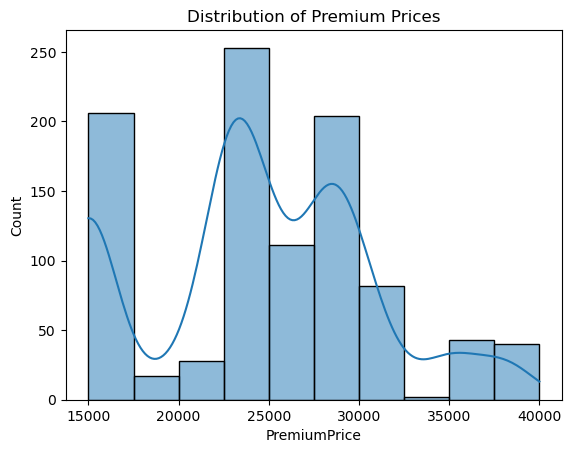

In [5]:
# Histplot of Distribution of Premium Prices
sns.histplot(data=df, x='PremiumPrice',bins=10, kde=True)
plt.title('Distribution of Premium Prices')
plt.gca().set_facecolor('white');

- The PremiumPrice response variable does not follow a normal distribution. To account for this, it may be necessary to utilize transformation techniques when constructing models.

# **Correlation Map**

<AxesSubplot: >

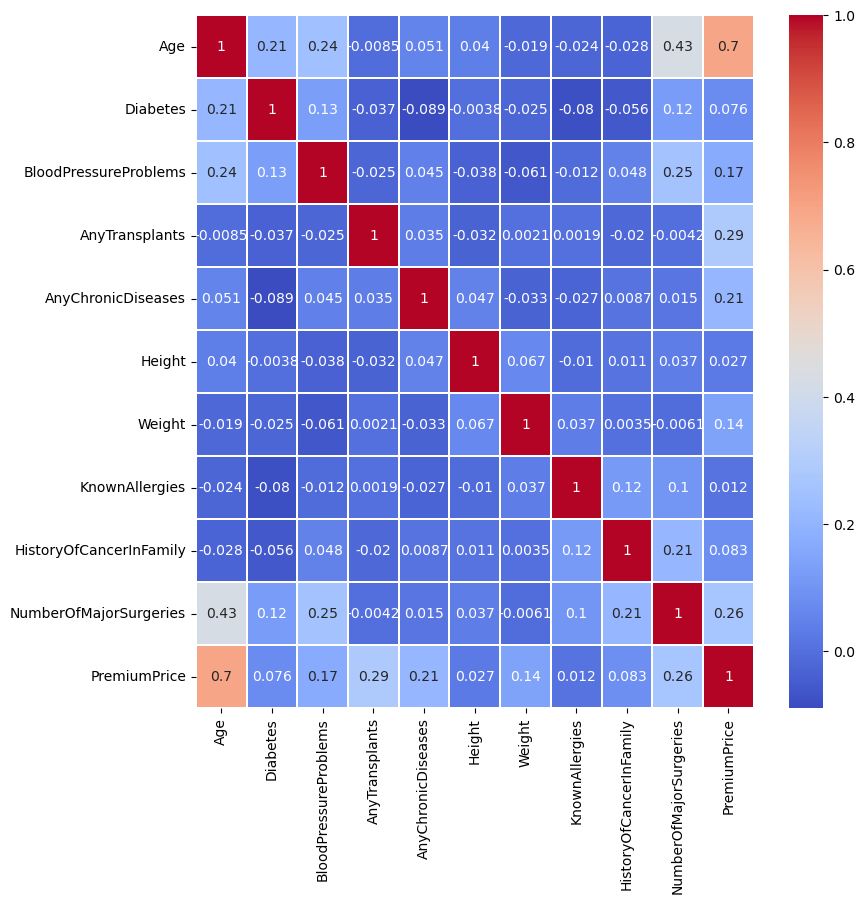

In [6]:
# Correlation Heatmap 
plt.figure(figsize=(9,9))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True,linewidths=0.1)

- The Age of the customer has a significant impact on Premium Price, as indicated by a strong positive correlation coefficient of +0.71.
- Conversely, there are several variables that exhibit a weak correlation with Premium Price, and these variables should be disregarded or reevaluated when developing the model.

# **Exploratory Visualizations**

## **Age**

<AxesSubplot: xlabel='Age', ylabel='PremiumPrice'>

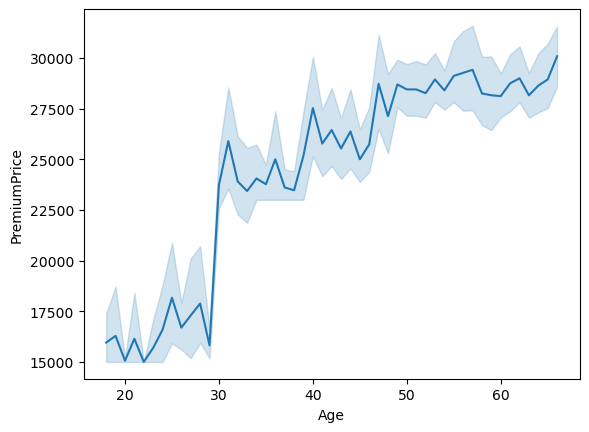

In [7]:
# Lineplot of Age
sns.lineplot(x=df.Age,y=df.PremiumPrice)

## **Height**

<AxesSubplot: xlabel='Height', ylabel='PremiumPrice'>

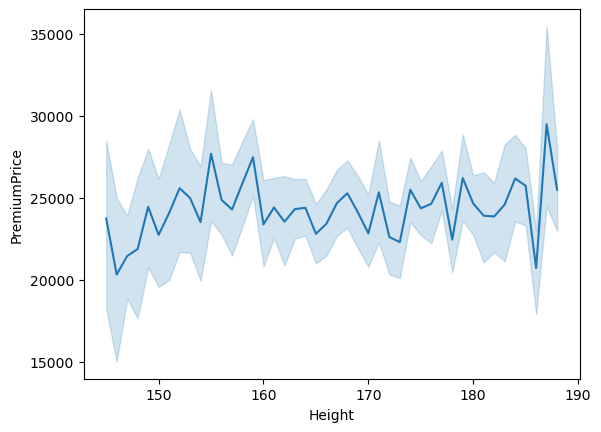

In [8]:
# Lineplot of Height
sns.lineplot(x=df.Height,y=df.PremiumPrice)

## **Weight**

<AxesSubplot: xlabel='Weight', ylabel='PremiumPrice'>

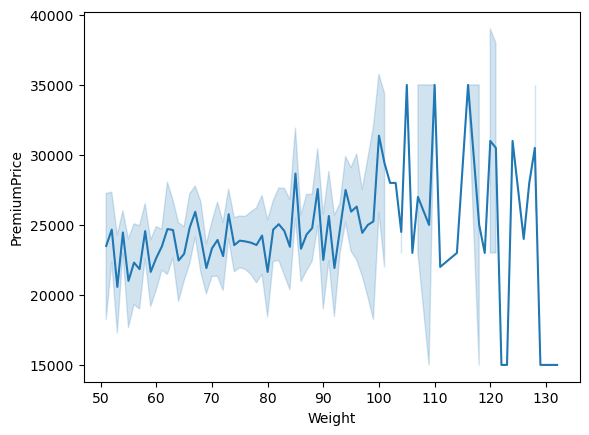

In [9]:
# Lineplot of Weight
sns.lineplot(x=df.Weight,y=df.PremiumPrice)

- The scatterplot shows no discernible pattern that suggests a positive or negative relationship between height and weight.
- Similarly, there appears to be no significant correlation between height and weight with Premium Price. 
- Therefore, it may be advisable to either exclude these variables from the model or create a new variable such as BMI, which would have a more pronounced effect on Premium Price.

# **EDA on Qualitative variables**

In [10]:
# Creating Dictionary of Categorical variables
Categorical_Variables = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases','KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']

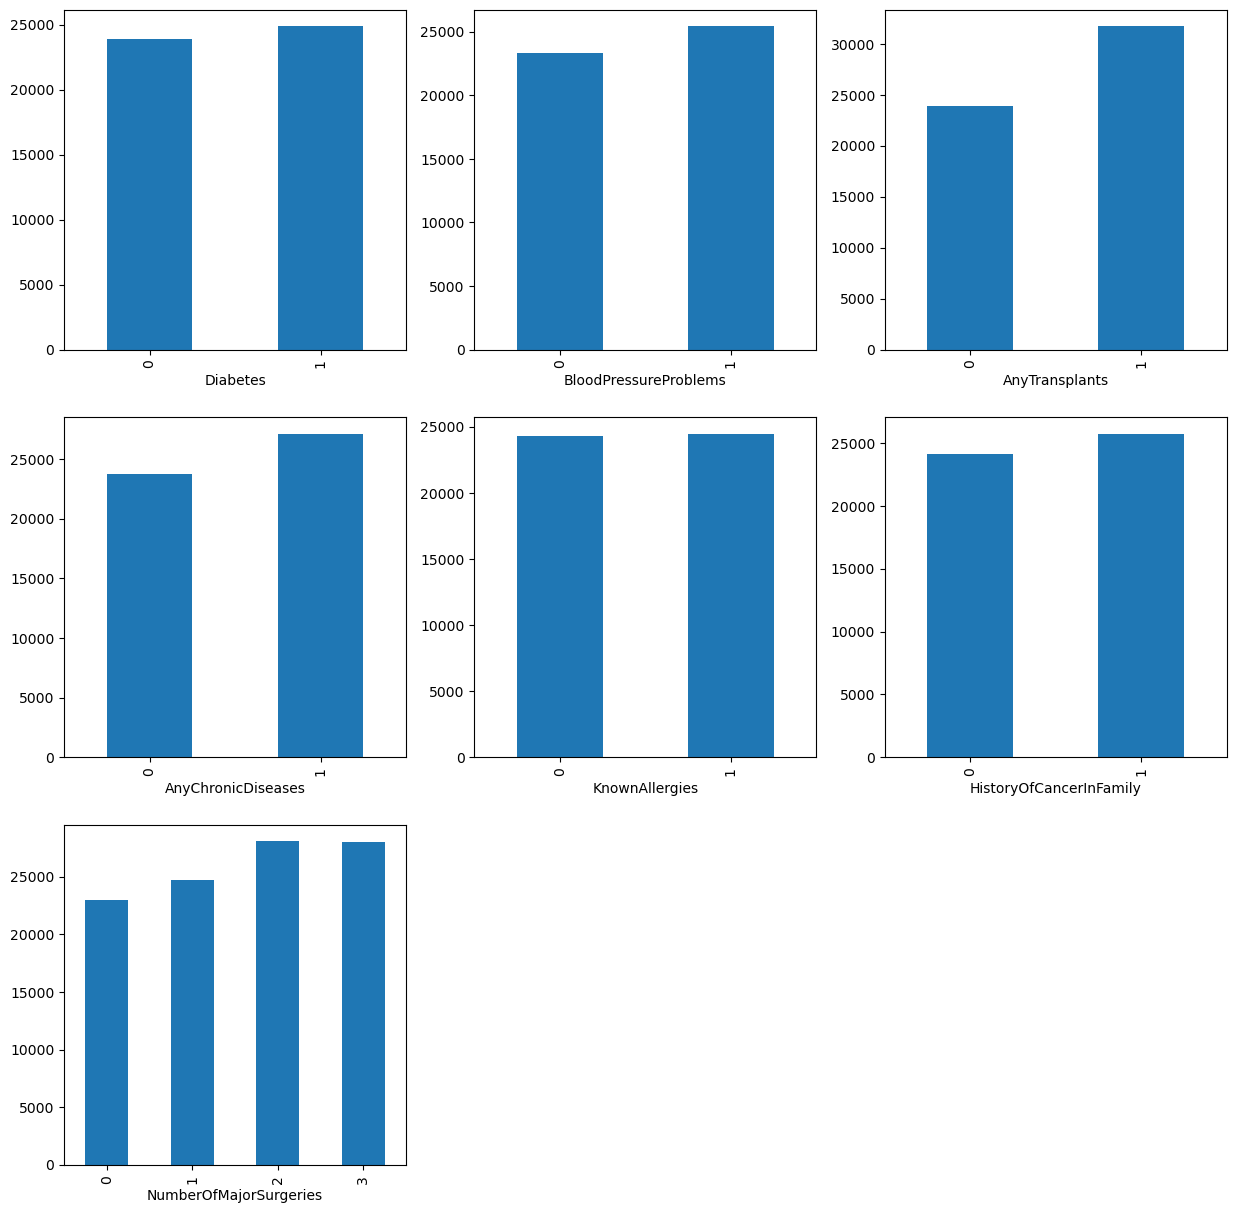

In [11]:
# Visualization of Categorical Variables
plt.figure(figsize=(15,15))
a = 3
b = 3
c = 1
# For loop to show premium price for subplots
for feature in Categorical_Variables:
    plt.subplot(a,b,c)
    df.groupby(feature)['PremiumPrice'].mean().plot.bar()
    c=c+1
    
plt.show()

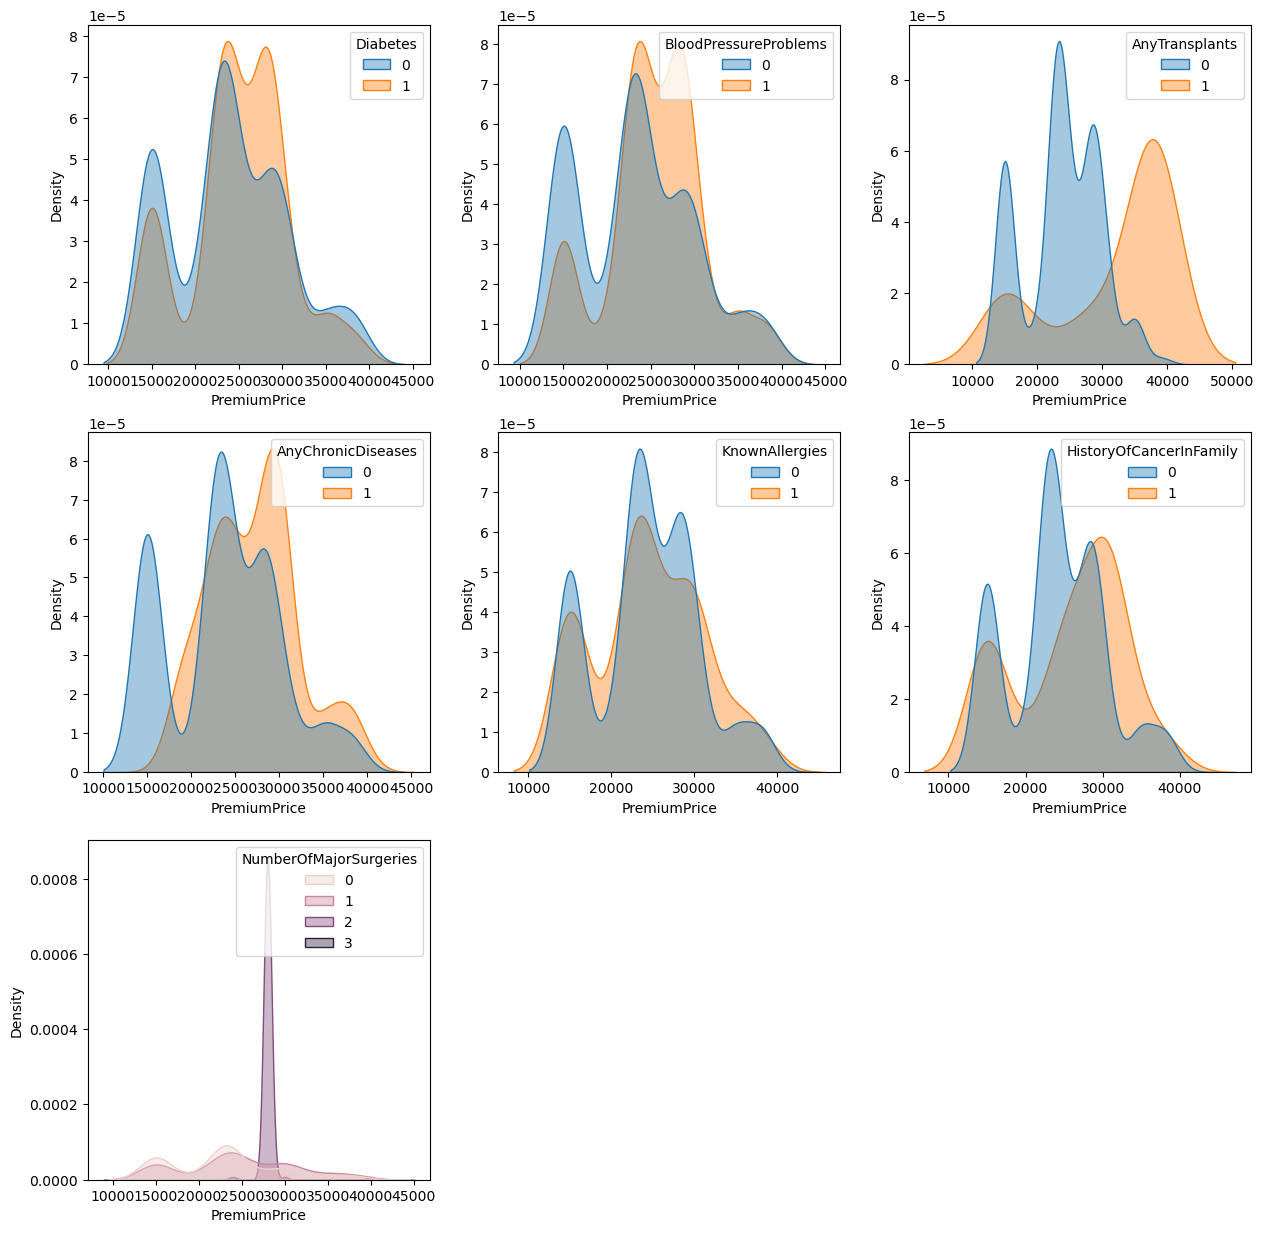

In [12]:
# Further visualizing categorical variables
plt.figure(figsize=(15,15))
a = 3
b = 3
c = 1
# For loop showing premium price for kde subplots
for feature in Categorical_Variables:
    plt.subplot(a,b,c)
    sns.kdeplot(x='PremiumPrice', data=df, hue=feature, fill=True, common_norm=False, 
                alpha =0.4, warn_singular=False)
    c=c+1
plt.show()

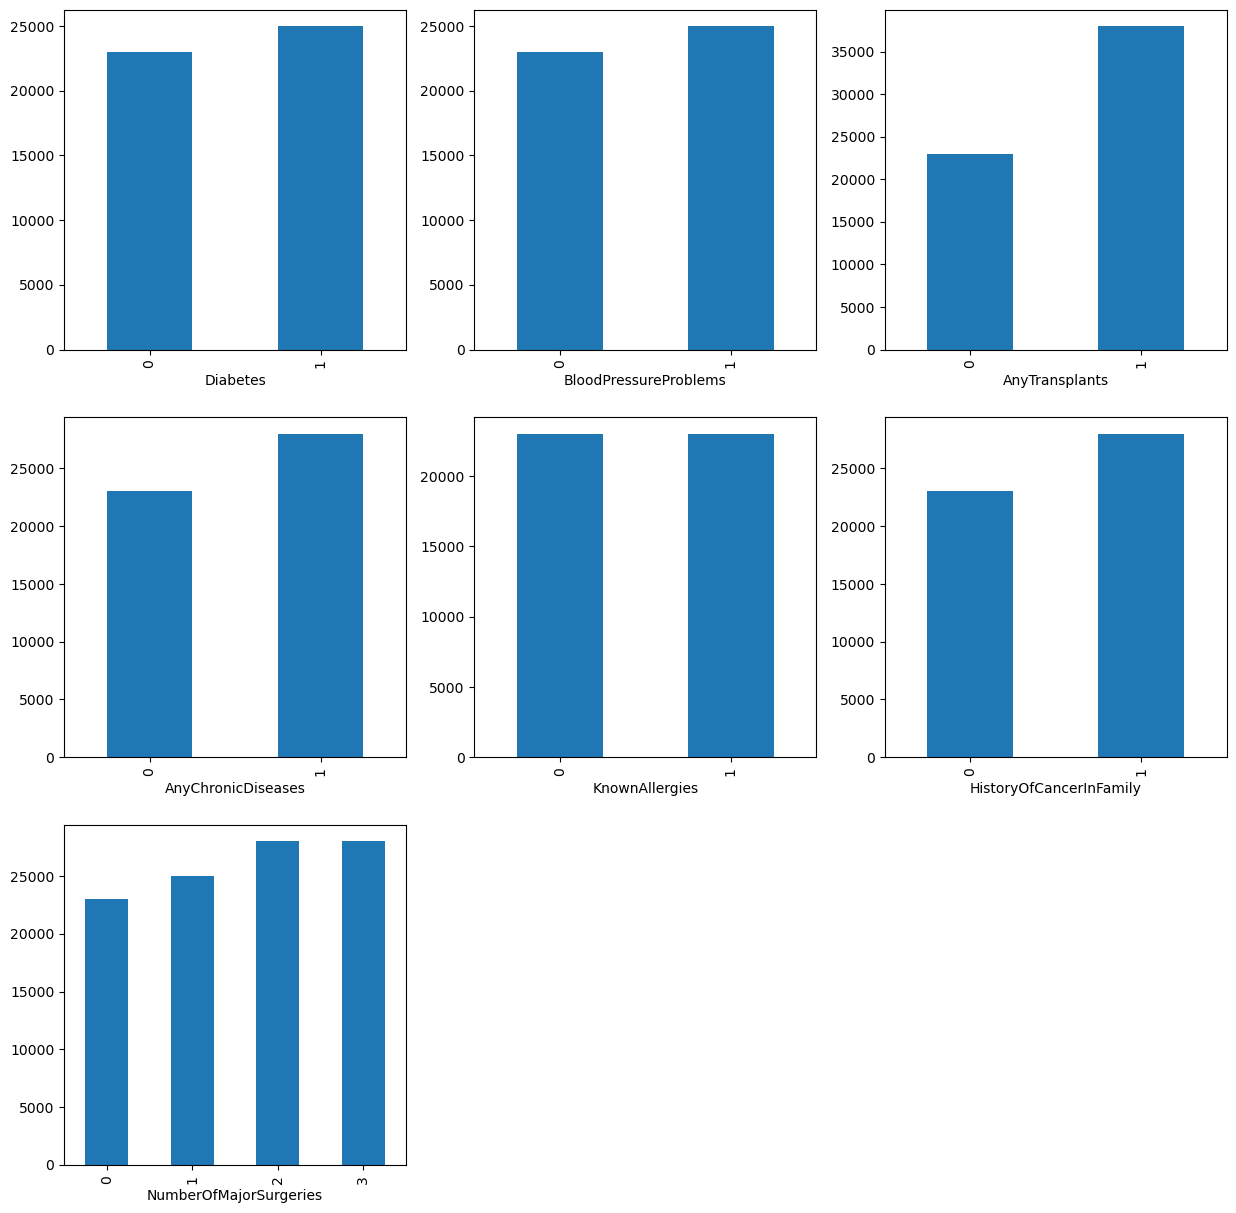

In [13]:
# Further Visualizing categorical variables
plt.figure(figsize=(15,15))
a = 3
b = 3
c = 1
# For loop showing premuim price for bar plots
for feature in Categorical_Variables:
    plt.subplot(a,b,c)
    df.groupby(feature)['PremiumPrice'].median().plot.bar()
    c=c+1   
plt.show()

- Based on the graphs above, it is evident that certain variables, such as "AnyTransplants", "AnyChronicDiseases", "HistoryOfCancerInFamily", and "NumberOfMajorSurgeries", have a notable influence on Premium Price. 
- Conversely, other variables do not appear to have a significant impact on  the Premium Price.

# **New Variables**

- Weight and height do not appear to significantly affect the premium price. 
- Therefore, creating a new variable, BMI, using these variables may have a greater impact on the premium price. However, analyzing individuals based solely on their BMI value may not yield conclusive results.
- Instead, categorizing people based on their BMI value and analyzing the categories may provide more insightful information.

- BMI less than 18.5, falls within the underweight range.
- BMI 18.5 to <25, falls within the normal weight range.
- BMI 25.0 to <30, falls within the overweight range.
- BMI 30.0 or higher, falls within the obesity range

In [14]:
# Calculate and add BMI column to DataFrame
df['BMI'] = df.Weight.values/(((df.Height).values/100)**2)
# Display first few rows of DataFrame
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,BMI
0,45,0,0,0,0,155,57,0,0,0,25000,23.725286
1,60,1,0,0,0,180,73,0,0,0,29000,22.530864
2,36,1,1,0,0,158,59,0,0,1,23000,23.634033
3,52,1,1,0,1,183,93,0,0,2,28000,27.770313
4,38,0,0,0,1,166,88,0,0,1,23000,31.934969


In [15]:
# Identify the index of individuals who are underweight
under_index = df[df.BMI<18.4999].index
# Identify the index of individuals who have normal weight
normal_index = df[(df.BMI>18.5) & (df.BMI<24.9999)].index
# Identify the index of individuals who are overweight
over_index = df[(df.BMI>25) & (df.BMI<29.9999)].index
# Identify the index of individuals who have obesity
obecity_index = df[df.BMI>30].index
# Assign 'Under Weight' status to the individuals with BMI less than 18.5
df.loc[under_index,'BMI_Status'] = 'Under Weight'
# Assign 'Normal' status to the individuals with BMI between 18.5 and 24.9999
df.loc[normal_index,'BMI_Status'] = 'Normal'
# Assign 'Over Weight' status to the individuals with BMI between 25 and 29.9999
df.loc[over_index,'BMI_Status'] = 'Over Weight'
# Assign 'Obecity' status to the individuals with BMI greater than 30
df.loc[obecity_index,'BMI_Status'] = 'Obecity'

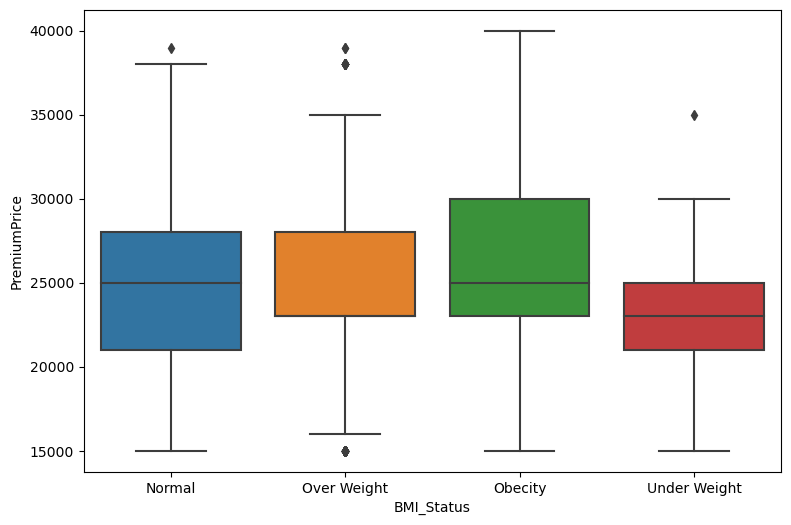

In [16]:
# Set the figure size
plt.figure(figsize=(9,6))
# Create a box plot to visualize relationship between BMI status and premium price
ax = sns.boxplot(x='BMI_Status', y='PremiumPrice', data=df)

- According to these visualizations, people who have obesity and overweight problems are more likely to have higher premium prices.

# **Data Cleaning**

In [17]:
# Convert categorical column 'BMI_Status' into dummy variables
df_BMI_Status = pd.get_dummies(df.BMI_Status)
# Concatenate the original DataFrame with the new dummy variables
df = pd.concat([df,df_BMI_Status], axis=1)
# Drop the original 'BMI_Status' and 'BMI' columns from the DataFrame
df = df.drop(['BMI_Status','BMI'],axis=1)

# **Validation Split**

In [18]:
# Separate the target variable 'PremiumPrice' from the feature variables in the DataFrame
X = df.drop('PremiumPrice', axis =1)
y = df['PremiumPrice']
# Split the data into training and testing sets using train_test_split function from sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

# **Random Forest Regressor**

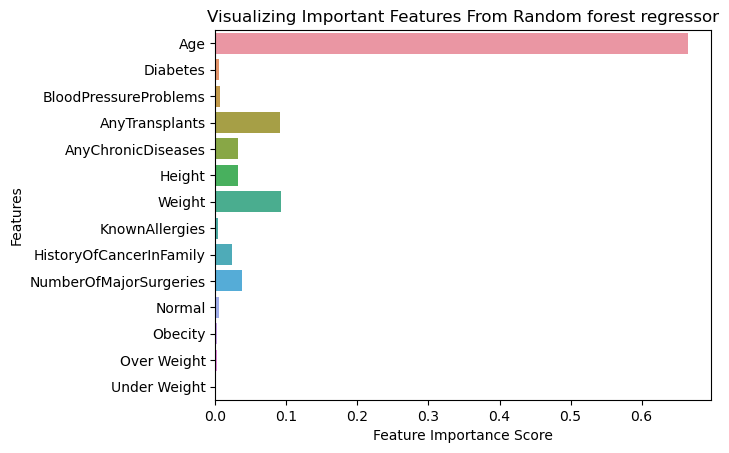

In [19]:
# Create a new instance of the RandomForestRegressor class
random_forest = RandomForestRegressor()
# Fit the random forest model using the training data
random_forest.fit(X_train,y_train)
# Calculate the feature importances from the random forest model
feature_imp1 = random_forest.feature_importances_
# Create a bar plot to visualize the feature importances
sns.barplot(x=feature_imp1, y=X.columns)
# Add labels and a title to the bar plot
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features From Random forest regressor")
# Display the bar plot
plt.show();

# **XGBRF Regressor**

C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


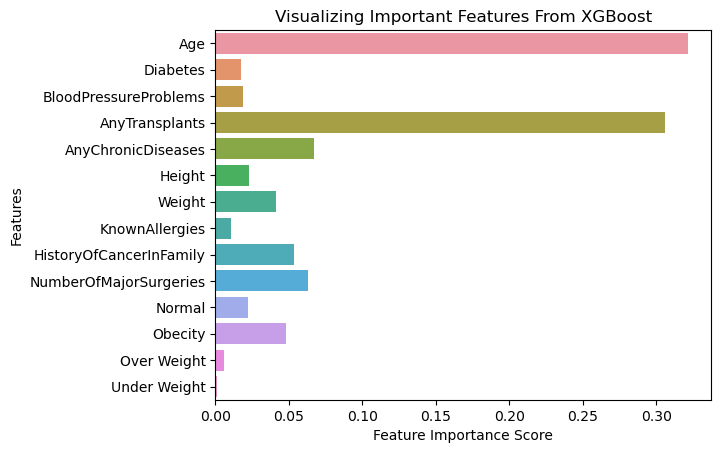

In [20]:
# Create a new instance of the XGBRFRegressor class
xgboost = XGBRFRegressor()
# Fit the XGBoost model using the training data
xgboost.fit(X_train, y_train)
# Calculate the feature importances from the XGBoost model
feature_imp2 = xgboost.feature_importances_
# Create a bar plot to visualize the feature importances
sns.barplot(x=feature_imp2, y=X.columns)
# Add labels and a title to the bar plot
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features From XGBoost")
# Display the bar plot
plt.show();

# **Linear Regression model**

In [21]:
# Create a new instance of the LinearRegression class
regressor = LinearRegression()
# Fit the regression model using the training data
regressor.fit(X_train, y_train)
# Use the fitted regression model to predict the target variable on the test set
y_pred = regressor.predict(X_test)
# Calculate the R-squared score to evaluate the regression model's performance
print(r2_score(y_test, y_pred))

0.6723506429733634


In [22]:
# Create a new instance of the GradientBoostingRegressor class
regressor = GradientBoostingRegressor(n_estimators=15)
# Fit the regression model using the training data
regressor.fit(X_train, y_train)
# Use the fitted regression model to predict the target variable on the test set
y_pred = regressor.predict(X_test)
# Calculate the R-squared score to evaluate the regression model's performance
r2_score(y_test, y_pred)

0.6343131471832328

In [23]:
# Create a new instance of the Ridge regression class
regressor = Ridge()
# Fit the regression model using the training data
regressor.fit(X_train, y_train)
# Use the fitted regression model to predict the target variable on the test set
y_pred = regressor.predict(X_test)
# Calculate the R-squared score to evaluate the regression model's performance
r2_score(y_test, y_pred)

0.6704854760250658

In [24]:
# Create a new instance of the Lasso regression class
regressor = Lasso()
# Fit the regression model using the training data
regressor.fit(X_train, y_train)
# Use the fitted regression model to predict the target variable on the test set
y_pred = regressor.predict(X_test)
# Calculate the R-squared score to evaluate the regression model's performance
r2_score(y_test, y_pred)

0.6722664584779077

In [25]:
# Create instance of Random forest Regressor
regressor = RandomForestRegressor()
# fit model on the X_train and y_train
regressor.fit(X_train,y_train)
# Use the fitted regression model to predict the target variable on the test set
y_pred = regressor.predict(X_test)
# Calculate the R-squared score to evaluate the regression model's performance
print(r2_score(y_test, y_pred))

0.7650835897321229


In [26]:
# Create instance of XGBF Regressor
regressor = XGBRFRegressor()
# fit model on the X_train and y_train
regressor.fit(X_train,y_train)
# Use the fitted model to predict the target variable on the test set
y_pred = regressor.predict(X_test)
# Calculate the R-squared score to evaluate the model's performance
print(r2_score(y_test, y_pred))

0.7398830231090897


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


# **Hyperparameter Tuning**

In [27]:
# Create an instance of the RandomForestRegressor class
rf = RandomForestRegressor()
# Define hyperparameters to tune
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
max_features = ['auto', 'sqrt']
max_depth = [5, 10, 15, 20, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
# We store the hyperparameters in a dictionary
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Create an instance of the RandomizedSearchCV class, which performs a randomized search over the hyperparameters
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,
                               scoring='neg_mean_squared_error', 
                               n_iter = 10, cv = 5, verbose=2, 
                               random_state=42, n_jobs = 1)

In [28]:
# Fit on the training data
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   0.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   1.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   1.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   0.3s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   0.3s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   0.3s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   0.3s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   0.3s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   0.5s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   0.6s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   0.5s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   0.5s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   0.5s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   1.0s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   1.1s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   1.0s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   1.0s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time=   1.0s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.2s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.2s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.2s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.2s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=   1.0s
[CV] END max_depth=5, max_feat

C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   1.0s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   1.0s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   1.0s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   1.0s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time=   1.0s


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [29]:
# search for best parameters
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

# **Classification**

- The accuracy of the regression models was less than satifactory, I'm going to investigate weather or not better results can be found by converting this into a classifction problem.

In [30]:
# define a list of premium labels
pr_lab=['Low','Basic','Average','High','SuperHigh']
# Create a new column in the dataframe called "PremiumLabel" and assign the binned values of the "PremiumPrice" column
df['PremiumLabel'] = pr_bins = pd.cut(df['PremiumPrice'], bins=5, labels=pr_lab, precision=0)
# Display the first few rows of the modified dataframe
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,Normal,Obecity,Over Weight,Under Weight,PremiumLabel
0,45,0,0,0,0,155,57,0,0,0,25000,1,0,0,0,Basic
1,60,1,0,0,0,180,73,0,0,0,29000,1,0,0,0,Average
2,36,1,1,0,0,158,59,0,0,1,23000,1,0,0,0,Basic
3,52,1,1,0,1,183,93,0,0,2,28000,0,0,1,0,Average
4,38,0,0,0,1,166,88,0,0,1,23000,0,1,0,0,Basic


In [31]:
# Create an instance of the OrdinalEncoder class and specify the column to encode and the mapping of labels to integers
encoder_PremiumLabel = ce.OrdinalEncoder(cols=['PremiumLabel'], return_df=True, mapping=[{'col': 'PremiumLabel', 'mapping': {'Low': 0, 'Basic': 1, 'Average': 2, 'High': 3, 'SuperHigh': 4}}])
# Apply the encoder to the dataframe to transform the "PremiumLabel" column from categorical labels to ordinal integers
df = encoder_PremiumLabel.fit_transform(df)
# display the first few rows of the modified dataframe
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,Normal,Obecity,Over Weight,Under Weight,PremiumLabel
0,45,0,0,0,0,155,57,0,0,0,25000,1,0,0,0,1
1,60,1,0,0,0,180,73,0,0,0,29000,1,0,0,0,2
2,36,1,1,0,0,158,59,0,0,1,23000,1,0,0,0,1
3,52,1,1,0,1,183,93,0,0,2,28000,0,0,1,0,2
4,38,0,0,0,1,166,88,0,0,1,23000,0,1,0,0,1


In [32]:
# Drop the "PremiumPrice" column from the dataframe using the "drop" method and the "axis" parameter
df = df.drop('PremiumPrice', axis=1)
# Create the X and y variables for the features and labels respectively, using the "drop" method to remove the "PremiumLabel" column from the features
X = df.drop('PremiumLabel', axis=1)
y = df['PremiumLabel']
# Import the train_test_split function from the sklearn.model_selection module
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets using the train_test_split function, with a test size of 20% and a random state of 0 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
# Create a random forest classifier object
classifier = RandomForestClassifier()
# Fit the classifier to the training data using the "fit" method
classifier.fit(X_train, y_train)
# Use the trained classifier to make predictions on the test data using the "predict" method
y_pred = classifier.predict(X_test)
# Create a confusion matrix to evaluate the performance of the classifier on the test data
cm = confusion_matrix(y_test, y_pred)
# Print the confusion matrix and the accuracy score of the classifier on the test data
print(cm)
print(accuracy_score(y_test, y_pred))

[[40  0  1  0  0]
 [ 2 77  0  0  0]
 [ 0  3 51  0  0]
 [ 0  2  4  7  0]
 [ 4  0  1  0  6]]
0.9141414141414141


In [34]:
# Create an XGBoost classifier object
classifier = XGBClassifier()
# Fit the classifier to the training data using the "fit" method
classifier.fit(X_train, y_train)
# Use the trained classifier to make predictions on the test data using the "predict" method
y_pred = classifier.predict(X_test)
# Create a confusion matrix to evaluate the performance of the classifier on the test data
cm = confusion_matrix(y_test, y_pred)
# Print the confusion matrix and the accuracy score of the classifier on the test data
print(cm)
print(accuracy_score(y_test, y_pred))

[22:36:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\davyd\anaconda3\envs\dojo-env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[[40  0  1  0  0]
 [ 2 77  0  0  0]
 [ 0  1 52  1  0]
 [ 0  1  1 11  0]
 [ 4  0  1  0  6]]
0.9393939393939394
